# TD N°2 explicabilité du dataset Boston Housing

1) Charger le dataset bostong_housing
   1) Disponible dans le folder 04_interpretable_ml/td/data/
   
2) Nettoyer votre jeu de données pour créer une régression linéaire et un random forest
   1) Tester d'ajouter des features log, quadratique, ...

3)Créer un modèle baseline linéaire et random forest

4) Interpréter le modèle linéaire

5) Tuner votre random forest

6) Interpréter globalement votre modèle meilleur modèle RF 
   1) Utiliser les PDP ou ALE & Permutation feature Importance 
   2) Comparer les résulats du random forest avec votre interprétation du modèle linéaire

6) Réaliser une explicabilité par individu
   1) En utilisant la méthode ICE (PDP individuelle)
   2) LIME (Model local pour expliquer une prédiction)
   3) SHAP watterfall plot (Contribution marginale de chaque variable dans la prédiction)

7) Réaliser une explicabilité par individu sur le modèle RF
- 1) ICE, le PDP est-il une bonne représentation des variables importantes de votre modèle?
- 2) LIME
- 3) SHAP watterfall plot

8) Explorer les graphiques SHAP étudiés  dans la partie CM
   1) beeswarm (Contribution des variables)
   2) scatter (équivalent pdp)

# Contexte du Dataset

Le Boston Housing Dataset est un ensemble de données couramment utilisé en apprentissage automatique et en statistique pour étudier les relations entre diverses caractéristiques socio-économiques et immobilières dans la ville de Boston.  
Il contient des informations sur des propriétés résidentielles et leur environnement, et est souvent utilisé pour prédire la valeur des maisons, un problème classique de régression.

**Variable dispo**: 
- CRIM : taux de criminalité par habitant par ville
- ZN : proportion de terrains résidentiels zonés pour des lots de plus de 25 000 pieds carrés
- INDUS : proportion de terrains commerciaux non commerciaux par ville
- CHAS : variable binaire indiquant la proximité de la rivière Charles (= 1 si la zone délimitée par la ville touche la rivière ; 0 sinon)
- NOX : concentration des oxydes d'azote (en parties par 10 millions)
- RM : nombre moyen de pièces par logement
- AGE : proportion des unités occupées par leur propriétaire et construites avant 1940
- DIS : distances pondérées vers cinq centres d'emploi de Boston
- RAD : indice d'accessibilité aux autoroutes radiales
- TAX : taux d'imposition foncière par valeur totale pour chaque tranche de 10 000 dollars
- PTRATIO : ratio élèves-enseignants par ville
- LSTAT : pourcentage de la population de statut socio-économique inférieur
- MEDV : valeur médiane des maisons occupées par leur propriétaire (en milliers de dollars) - **variable cible**

In [1]:
#Web request
import requests
import io
import pandas as pd

In [2]:
import pandas as pd                 # for data manipulation and analysis
import numpy as np                  # for mathematical operations
import plotly.express as px         # for data visualization
import seaborn as sns               # for data visualization
import matplotlib.pyplot as plt     # for data visualization

# Splitter le dataset
from sklearn.model_selection import train_test_split

# Standardisation
from sklearn.preprocessing import StandardScaler

# Modélisation
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, r2_score

from sklearn.model_selection import cross_val_score ,learning_curve ,GridSearchCV
from sklearn_evaluation import plot


#Interpretability
from sklearn.inspection import partial_dependence, PartialDependenceDisplay, permutation_importance
from alibi.explainers import ALE, plot_ale




import warnings
warnings.filterwarnings('ignore') # setting ignore as a parameter

C:\Users\Jasmine\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [3]:
def winsorize_data(xtrain, xtest, feature):

    """_summary_

    Fonction permettant de winsorizez un jeu d'entrainement et de test en calculant
    les quantiles sur le jeu d'entrainement et l'appliquant sur le jeu test.

    Pour se prémunir d'un data leak.
    
    """
    
    # Définir les quantiles sur xtrain
    lower_quantile = 0.05  # 5% quantile
    upper_quantile = 0.95  # 95% quantile

    # Calcul des bornes à partir des quantiles sur xtrain
    lower_bound = np.quantile(xtrain[feature], lower_quantile)
    upper_bound = np.quantile(xtrain[feature], upper_quantile)

    # Appliquer la winsorisation sur xtrain
    xtrain_winsorized = np.clip(xtrain[feature], lower_bound, upper_bound)

    # Appliquer les mêmes bornes sur xtest
    xtest_winsorized = np.clip(xtest[feature], lower_bound, upper_bound)

    return(xtrain_winsorized, xtest_winsorized)

# 1) Charger le dataset bostong_housing

In [4]:
#Télécharge directement depuis Github
url = "https://raw.githubusercontent.com/Roulitoo/cours_iae/master/04_INTERPRETABLE_ML/td/data/boston_housing.csv" 
download = requests.get(url).content

df = pd.read_csv(io.StringIO(download.decode('utf-8')), sep=';')

## a) Structure du jeu de données

In [5]:
df

,Unnamed: 0,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,MEDV
0,0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,4.98,24.0
1,1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,9.14,21.6
2,2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,4.03,34.7
3,3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,2.94,33.4
4,4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,9.67,22.4
502,502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,9.08,20.6
503,503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,5.64,23.9
504,504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,6.48,22.0


Nous voyons que la colonne **Unnamed: 0** correspondant à l'identifiant des lignes du dataframe n'apporte pas d'informations pertinentes pour la modélisation. Nous allons donc la supprimer.

In [6]:
df = df.drop(columns=['Unnamed: 0'])

In [7]:
df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,6.48,22.0


In [8]:
# Afficher le nombre de lignes et de colonnes
nb_lignes, nb_colonnes = df.shape
print(f"Nombre de lignes : {nb_lignes}")
print(f"Nombre de colonnes : {nb_colonnes}")

Nombre de lignes : 506
Nombre de colonnes : 13


Le jeu de données comporte 506 observations et 13 colonnes.

# 2) Nettoyer votre jeu de données pour créer une régression linéaire et un random forest

Penser à :

- Vérifier comment encoder vos variables qualitatives pour la modélisation 
- Analyser les distributions
- Analyser les outliers 
- Analyser les corrélations

>Tester d'ajouter des features log, quadratique, ...

## a) Etude des valeurs manquantes

In [9]:
valeurs_manquantes = df.isnull().sum()
print("Nombre de valeurs manquantes par colonne :")
print(valeurs_manquantes)

Nombre de valeurs manquantes par colonne :
CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
LSTAT      0
MEDV       0
dtype: int64


Le jeu de données ne comporte pas de valeurs manquantes.

## b) Type des variables

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  LSTAT    506 non-null    float64
 12  MEDV     506 non-null    float64
dtypes: float64(11), int64(2)
memory usage: 51.5 KB


Nous remarquons que les variables **CHAS** et **RAD** sont formatées en nombres entiers. Or, la première variable est binaire indiquant si la zone délimitée par la ville touche la rivière ou non, et la deuxième correspond à un indice d'accessibilité aux autoroutes radiales. Au vue de leur construction, nous pouvons les percevoir comme des variables qualitatives. Par conséquent, nous allons leur affecter le type catégoriel.

In [11]:
# Convertir en type catégoriel
df['CHAS'] = df['CHAS'].astype('category')
df['RAD'] = df['RAD'].astype('category')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   CRIM     506 non-null    float64 
 1   ZN       506 non-null    float64 
 2   INDUS    506 non-null    float64 
 3   CHAS     506 non-null    category
 4   NOX      506 non-null    float64 
 5   RM       506 non-null    float64 
 6   AGE      506 non-null    float64 
 7   DIS      506 non-null    float64 
 8   RAD      506 non-null    category
 9   TAX      506 non-null    float64 
 10  PTRATIO  506 non-null    float64 
 11  LSTAT    506 non-null    float64 
 12  MEDV     506 non-null    float64 
dtypes: category(2), float64(11)
memory usage: 45.1 KB


Les données sont bien formatées.

## c) Analyse exploratoire 

L'analyse exploratoire est nécessaire avant la réalisation de la modélisation. En effet, elle permet de mieux comprendre le jeu de données à travers différentes représentations graphiques selon la nature des variables et de détecter in fine la présence ou non de valeurs aberrantes. Ces dernières seront à corriger car elles pourraient biaiser les résultats de la prédiction de la valeur médiane des maisons occupées par leur propriétaire.

### 1. Statistiques descriptives classiques des variables quantitatives

In [13]:
# Statistiques descriptives 
df_quanti = df.drop(columns=['CHAS', 'RAD'])
df_quanti.describe()

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,TAX,PTRATIO,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.554695,6.284634,68.574901,3.795043,408.237154,18.455534,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.115878,0.702617,28.148861,2.105710,168.537116,2.164946,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.385000,3.561000,2.900000,1.129600,187.000000,12.600000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.449000,5.885500,45.025000,2.100175,279.000000,17.400000,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.538000,6.208500,77.500000,3.207450,330.000000,19.050000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.624000,6.623500,94.075000,5.188425,666.000000,20.200000,16.955000,25.000000
max,88.976200,100.000000,27.740000,0.871000,8.780000,100.000000,12.126500,711.000000,22.000000,37.970000,50.000000


Au regard du tableau récapitulatif des statistiques des variables quantitatives, nous pouvons soupçonner la présence de valeurs aberrantes. En effet, les variables **CRIM** et **ZN** correspondant respectivement au taux de criminalité par habitant par ville et à la  proportion de terrains résidentiels zonés pour des lots de plus de 25 000 pieds carrés ont un écart-type qui est bien supérieur à leur moyenne. Cela indique une forte dispersion des valeurs causée par des valeurs très élevées pour ces deux variables.

### 2. Etude des outliers : boxplots des variables quantitatives standardisées

Nous allons procéder à une standardisation des données qui permet de mettre les données à la même échelle pour avoir une meilleure lisibilité des graphiques.

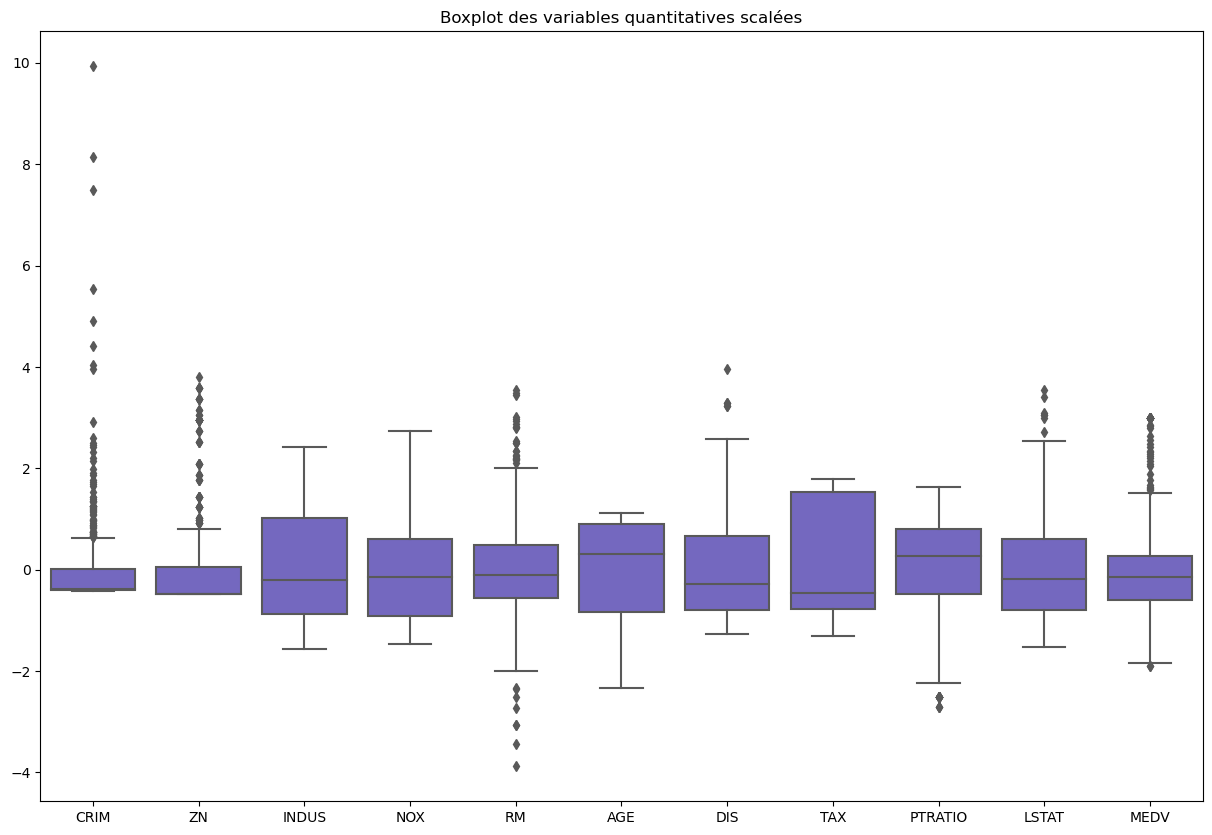

In [14]:
# Appliquer la standardization (z-score)
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(df_quanti), columns=df_quanti.columns)


# Créer un boxplot pour toutes les variables numériques
plt.figure(figsize=(15, 10))
sns.boxplot(data=data_scaled, color='slateblue')
plt.title('Boxplot des variables quantitatives scalées')


# Afficher le graphique
plt.show()

Les boîtes à moustaches appuient l'observation faite avec le tableau des statistiques descriptives : les variables **CRIM** et **ZN** possèdent de nombreux outliers, très éloignés de la distribution pour la première. D'autres variables comme **RM**, **DIS**, **PTRATIO**, **LSTAT**, **MEDV** ont également des points mais ne semblent pas être des outliers car ils n'ont pas d'influence sur la distribution d'après le tableau. <br>
Avant de procéder à la modélisation, il faudra donc corriger les données de ces outliers.

### 3. Analyse univariée des variables non standardisées

#### Variable cible

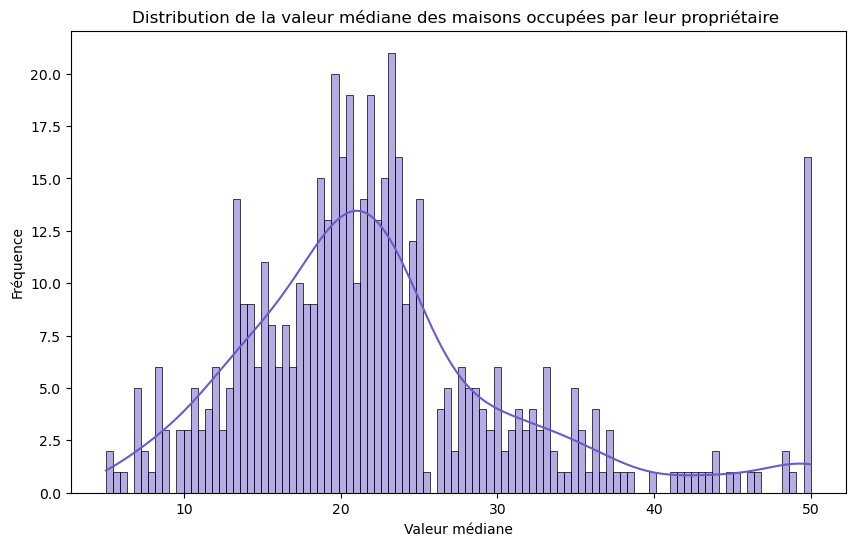

In [15]:
#kde=True pour avoir la densité en plus de l'histogramme
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Afficher l'histogramme avec la courbe KDE et un plus grand nombre de bins
sns.histplot(data=df_quanti, x="MEDV", color="slateblue", kde=True, bins=100, ax=ax)

# Ajouter un titre et des labels pour plus de clarté
ax.set_title("Distribution de la valeur médiane des maisons occupées par leur propriétaire ")
ax.set_xlabel("Valeur médiane")
ax.set_ylabel("Fréquence")

plt.show()

La distribution de la variable cible n'est pas symétrique à cause de la présence de valeurs très élevées tirant ainsi la distribution vers la droite. De plus, nous pouvons observer une concentration de valeurs dans l'intervalle [15;25].

#### Prédicteurs quantitatifs

<Figure size 1500x1000 with 0 Axes>

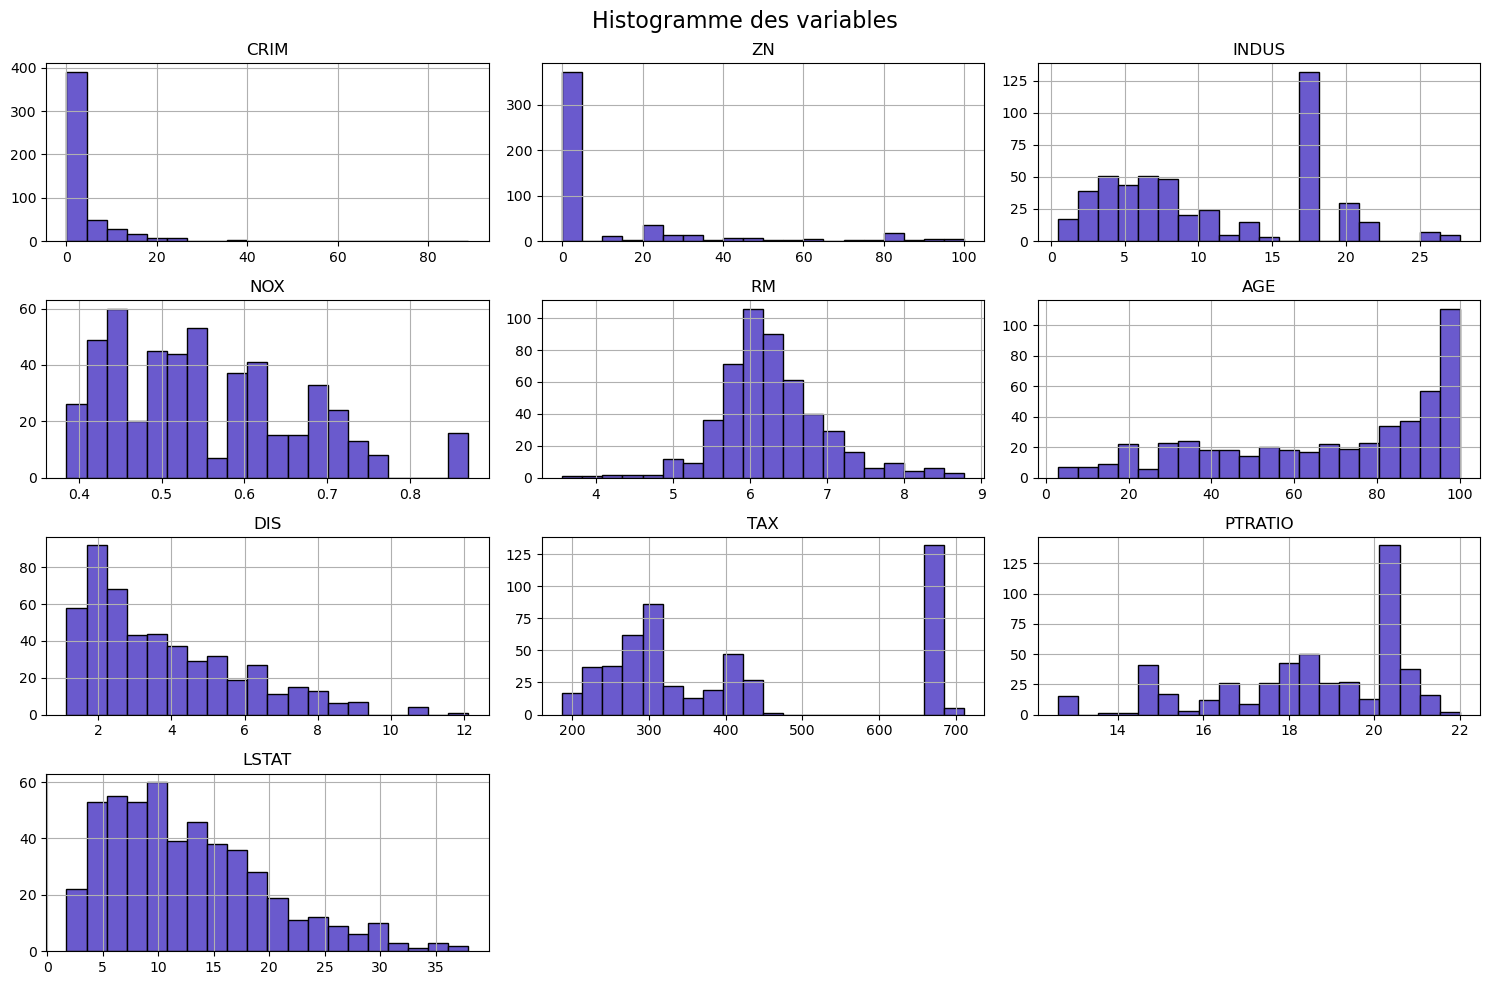

In [16]:
#Exclure la variable "MEDV"
features_quanti = df_quanti.drop(columns=["MEDV"])

plt.figure(figsize=(15, 10))

features_quanti.hist(bins=20, edgecolor='black', figsize=(15, 10), color="slateblue")

plt.suptitle('Histogramme des variables', fontsize=16)
plt.tight_layout()
plt.show()

Pareillement à la variable cible, les prédicteurs quantitatifs ne présentent pas de distributions symétriques. Toutefois, la variable **TAX** affiche une distribution assez équilibrée.

#### Prédicteurs qualitatifs

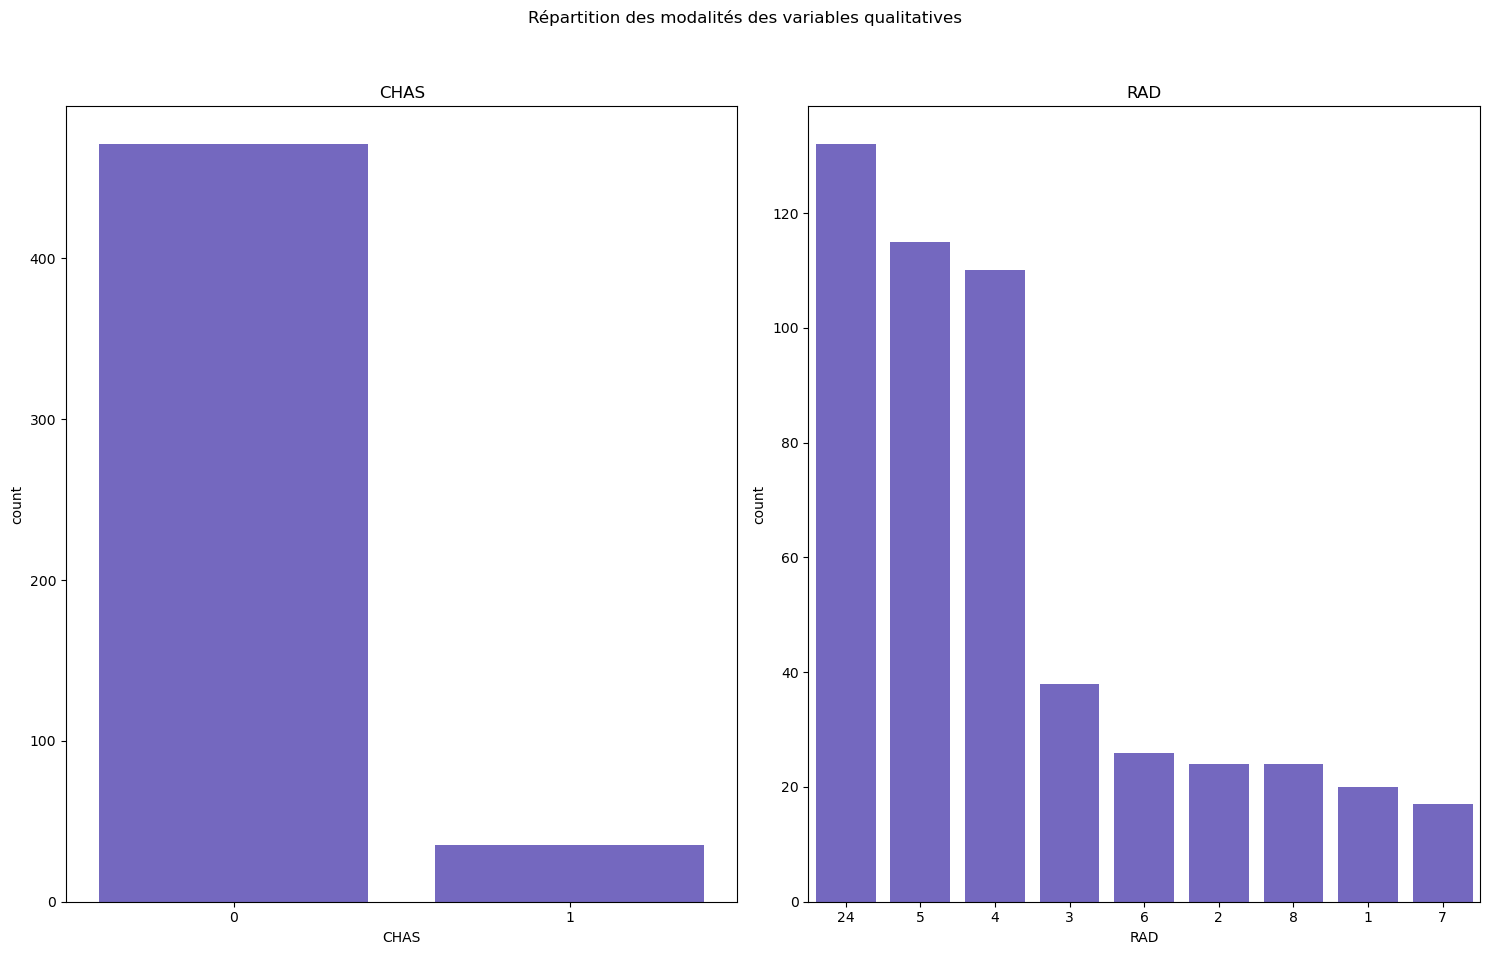

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
fig.suptitle('Répartition des modalités des variables qualitatives')

# CHAS
CHAS_order = df["CHAS"].value_counts().index
sns.countplot(ax=axes[0], x="CHAS", data=df, color="slateblue", order=CHAS_order)
axes[0].set_title("CHAS")

# RAD
RAD_order = df["RAD"].value_counts().index
sns.countplot(ax=axes[1], x="RAD", data=df, color="slateblue", order=RAD_order)
axes[1].set_title("RAD")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Ajuster les espacements
plt.show()

Ces différents diagramme en bâtons permettent d'observer les principales caractéristiques des propriétés résidentielle de notre échantillon. Ainsi, le jeu de données est majoritairement constitué de zones délimitées par la ville de Boston éloignées de la rivière dont l'indice d'accessiblité aux autoroutes radiales est élevé.

### 3. Analyse bivariée des variables non standardisées

#### Etude des corrélations

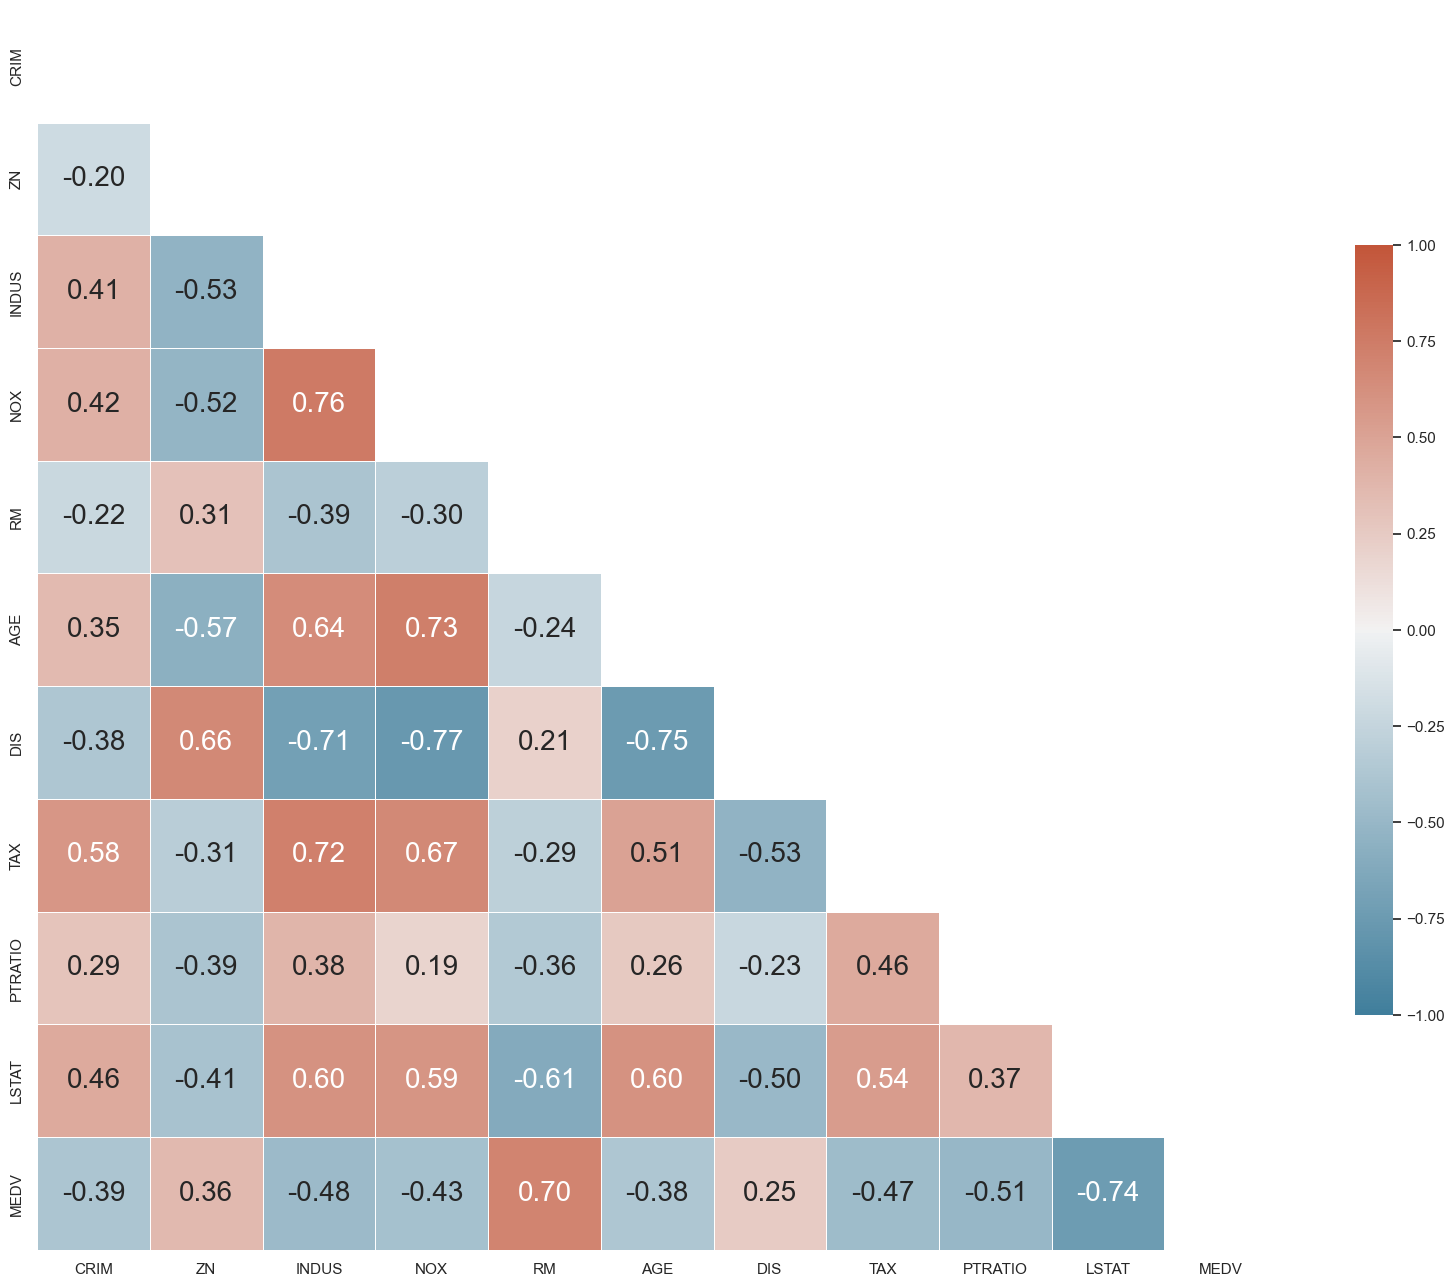

In [18]:
sns.set(style="white")

# On calcule la matrice de corrélation
corr = df_quanti.corr()

# On génère un masque pour le triangle supérieur
mask = np.triu(np.ones_like(corr, dtype=bool))

# On crée la figure matplotlib
fig, ax = plt.subplots(figsize=(20, 20))

# Une palette de couleurs
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# On dessine la heatmap avec le masque et un ratio d'aspect
sns.heatmap(corr,
            mask=mask,
            cmap=cmap,
            vmax=1,
            vmin=-1,
            center=0,
            square=True,
            linewidths=.5,
            cbar_kws={"shrink": .5},
            annot=True,
            annot_kws={"size": 20},
            fmt='.2f'
            )
plt.show()

Selon la matrice des corrélations, nous observons que certaines variables ont une corrélation assez forte entre elles. <br>  <br>
Signe positif :
- **NOX et INDUS** (0.76), 
- **AGE et NOX** (0.73),
- **TAX et INDUS** (0.72)
- **MEDV et RM** (0.70)

Signe négatif :
- **DIS et Indus** (-0.71)
- **DIS et NOX** (-0.77)
- **DIS et AGE** (-0.75)
- **MEDV et LSTAT** (-0.74)

Nous voyons que les corrélations non négligeables sont supérieures ou égales au seuil de 0.7 en valeur absolue. Malgré ce constat, nous décidons de conserver toutes les variables car elles peuvent jouer un rôle dans la prédiction de la valeur des maisons avec les variables qualitatives, prenant alors le risque d'une redondance d'information.

In [19]:
# MEDV correlation
corr.sort_values(by=["MEDV"], ascending=False).iloc[0].abs().sort_values(ascending=False)

MEDV       1.000000
LSTAT      0.737663
RM         0.695360
PTRATIO    0.507787
INDUS      0.483725
TAX        0.468536
NOX        0.427321
CRIM       0.388305
AGE        0.376955
ZN         0.360445
DIS        0.249929
Name: MEDV, dtype: float64

En valeur absolue, les variables les plus corrélées avec la variable cible sont **LSTAT** (Pourcentage de la population de statut socio-économique inférieur) et **RM** (nombre moyen de pièces par logement). Nous les gardons tout de même car elles représentent des critères essentiels dans l'estimation du prix de l'immobilier.

#### Liens entre les variables qualitatives = utilisation du test de Chi2

In [20]:
df_quali = df.drop(columns=df_quanti.columns)

from scipy.stats import chi2_contingency
# Création d'un tableau pour stocker les résultats (dépendant ou non)
dependency_table = pd.DataFrame(index=df_quali.columns, columns=df_quali.columns)

# Test du chi-deux pour chaque paire de variables
for col1 in df_quali.columns:
    for col2 in df_quali.columns:
        if col1 != col2:
            contingency_table = pd.crosstab(df_quali[col1], df_quali[col2])
            chi2, p, _, _ = chi2_contingency(contingency_table)
            dependency_table.loc[col1, col2] = "Oui" if p < 0.05 else "Non"

# Affichage du tableau des résultats de dépendance
print("Tableau des résultats de dépendance entre les variables (seuil=0.05) :")
dependency_table

Tableau des résultats de dépendance entre les variables (seuil=0.05) :


,CHAS,RAD
CHAS,NaN,Non
RAD,Non,NaN


Les résultats du test montrent que nos variables qualitatives ne sont pas liées entre elles. 

L'analyse du lien entre les variables qualitatives clôture la partie centrée sur l'analyse exploratoire. Nous allons à présent procéder à la modélisation de la prédiction de la valeur des maisons.

## 3) Créer 2 modèles baseline, linéaire et random forest

### 1. Préparation des données

#### Encodage des variables qualitatives

In [21]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

# Appliquer LabelEncoder à la variable RAD
df['RAD'] = label_encoder.fit_transform(df['RAD'])

 # Afficher les correspondances
print(f"Colonne : RAD")
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

df.head(5)

Colonne : RAD
{1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 24: 8}


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,0,296.0,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,1,242.0,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,1,242.0,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,2,222.0,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,2,222.0,18.7,5.33,36.2


A l'aide de cette fonction, nous avons pu transformer notre variable qualitative en variable quantivative grâce à l'affectation d'une valeur pour chacune des modalités. Par ailleurs, nous n'avons pas encodé notre variable binaire car les modèles de machine learning comprennent déjà ce type de valeurs.

#### Splitter le jeu de données

In [22]:
X = df.drop('MEDV', axis=1)
y = df['MEDV']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Winsoriser les données : correction des valeurs atypiques

In [23]:
for col in X_train.columns:
    print(f" winsorization de la variable : {col}") 
    X_train[col], X_test[col] = winsorize_data(xtrain= X_train, xtest= X_test, feature=col)

 winsorization de la variable : CRIM
 winsorization de la variable : ZN
 winsorization de la variable : INDUS
 winsorization de la variable : CHAS
 winsorization de la variable : NOX
 winsorization de la variable : RM
 winsorization de la variable : AGE
 winsorization de la variable : DIS
 winsorization de la variable : RAD
 winsorization de la variable : TAX
 winsorization de la variable : PTRATIO
 winsorization de la variable : LSTAT


#### Standardiser les données des jeux train et test

In [24]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

Nous standardisons les données pour pouvoir comparer les coefficients et leur ordre de grandeur.

### 2. Comparaison des modèles avec les paramètres par défaut 

Dans cette sous-section, nous allons procéder à l'application de 2 modèles pour prédire la valeur des maisons : Modèle linéaire et la forêt aléatoire. Nous mesurerons leur performance d'ajustement avec le R2 et de prédiction à l'aide du RMSE (Root Mean Squared Error). Ce dernier mesure la différence moyenne entre les valeurs prédites et les valeurs réelles. Pour ce faire, nous ferons appel à la validation croisée avec 5 folds qui est une méthode de *Machine Learning* permettant d'évaluer les performances des modèles d'apprentissage automatique.

Pour chaque algorithme de machine learning, nous ferons la modélisation du modèle avec les paramètres par défaut puis ferons une comparaison de leur performance en termes de RMSE et de R2. Cette dernière va nous permettre d'avoir un premier aperçu de la qualité des modèles.

#### 1) Comparaison des modèles avec les paramètres par défaut

In [25]:
# Régression linéaire
model = LinearRegression()
model.fit(X_train_sc, y_train)

#Random Forest
rfr = RandomForestRegressor(random_state=42)
rfr.fit(X_train_sc, y_train)

RandomForestRegressor(random_state=42)

- Qualité de prédiction : RMSE

In [26]:
# Get cross_val_score for each function
cvs_model = cross_val_score(model, X_train_sc, y_train, cv=5, scoring='neg_root_mean_squared_error')
cvs_rfr = cross_val_score(rfr, X_train_sc, y_train, cv=5, scoring='neg_root_mean_squared_error')

In [27]:
# Avoir le RMSE de chacun des modèles
rmse_model = -cvs_model
rmse_rfr = -cvs_rfr

In [28]:
#Get data output from cross_val_score
df_cross = pd.DataFrame(np.transpose(np.c_[rmse_model,rmse_rfr]), 
                        columns=['fold1','fold2','fold3','fold4','fold5'])
#Adding model label
df_cross['model'] = ['modèle linéaire','Random Forest']

In [29]:
df_cross

,fold1,fold2,fold3,fold4,fold5,model
0,4.500582,5.597636,4.479614,4.425842,5.201159,modèle linéaire
1,3.535119,4.552624,4.038234,3.238504,3.927739,Random Forest


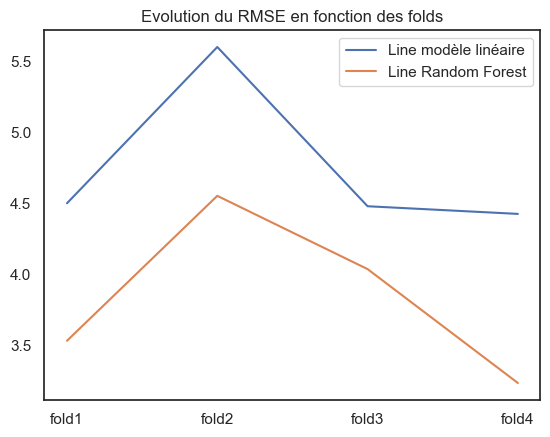

In [30]:
#Regardons l'évolution des scores pour chaque fold
for row in range(df_cross.shape[0]):
    plt.plot( df_cross.iloc[row,0:4] ,label='Line '+str(df_cross.iloc[row,5]))

plt.legend()
plt.title("Evolution du RMSE en fonction des folds")
plt.show()

In [31]:
for i in range(2):

    mean_model = df_cross.iloc[:,0:5].mean(axis=1)[i]
    std_model = df_cross.iloc[:,0:5].std(axis=1)[i]
    
    print('Le modèle N° '+ str(i) + ' a un RMSE de '  + str(mean_model) + ' et un std : ' + str(std_model))

Le modèle N° 0 a un RMSE de 4.840966660173484 et un std : 0.5293991380115753
Le modèle N° 1 a un RMSE de 3.858443962927287 et un std : 0.5019651601509469


#### Choix du modèle par rapport au RMSE

Nous prenons le modèle **RandomForest** comme modèle final. Il est celui qui a le meilleur RMSE en moyenne sur les folds de **3.86**.
A l'inverse, le modèle linéaire offre des performances plus faibles avec un RMSE plus élevé de 4.84, révélateur de mauvaises prédictions.

Toutefois, le modèle **RandomForest** a une variance équivalente entre les scores de ses folds avec **0.5** de std.

- Qualité d'ajustement : R2

In [32]:
# Get cross_val_score for each function
cvs_model_r2 = cross_val_score(model, X_train_sc, y_train, cv=5, scoring='r2')
cvs_rfr_r2 = cross_val_score(rfr, X_train_sc, y_train, cv=5, scoring='r2')

In [33]:
# Get data output from cross_val_score
df_cross_r2 = pd.DataFrame(np.transpose(np.c_[cvs_model_r2,cvs_rfr_r2]), 
                        columns=['fold1','fold2','fold3','fold4','fold5'])
#Adding model label
df_cross_r2['model'] = ['modèle linéaire','Random Forest']

In [34]:
df_cross_r2

,fold1,fold2,fold3,fold4,fold5,model
0,0.735085,0.657830,0.796592,0.794956,0.612704,modèle linéaire
1,0.836553,0.773663,0.834701,0.890215,0.779135,Random Forest


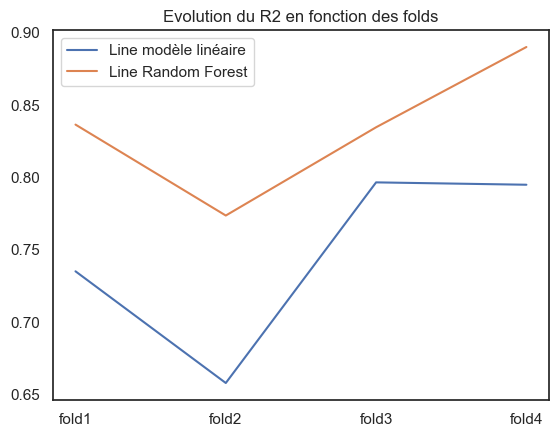

In [35]:
# Regardons l'évolution des scores pour chaque fold
for row in range(df_cross_r2.shape[0]):
    plt.plot( df_cross_r2.iloc[row,0:4] ,label='Line '+str(df_cross_r2.iloc[row,5]))

plt.legend()
plt.title("Evolution du R2 en fonction des folds")
plt.show()

In [36]:
for i in range(2):

    mean_model = df_cross_r2.iloc[:,0:5].mean(axis=1)[i]
    std_model = df_cross_r2.iloc[:,0:5].std(axis=1)[i]
    
    print('Le modèle N° '+ str(i) + ' a un R2 de '  + str(mean_model) + ' et un std : ' + str(std_model))

Le modèle N° 0 a un R2 de 0.7194335122415474 et un std : 0.08229253492761188
Le modèle N° 1 a un R2 de 0.8228532430613529 et un std : 0.04794967305852765


#### Choix du modèle par rapport au R2

Nous choisissons également le modèle **RandomForest** comme modèle final. Il est celui qui a le meilleur R2 en moyenne sur les folds de **0.83**.
A l'inverse, le modèle linéaire offre des performances plus faibles avec un R2 de 0.72.

De plus, le modèle **RandomForest** est celui qui a le moins de variance entre les scores de ses folds avec **0.05** de std.

### 4) Interpréter le modèle linéaire
Utiliser les méthodes intrinsèques du modèle pour l'interprétation

In [37]:
# Affichage de l'intercept
intercept = model.intercept_
print("Constante (intercept):", intercept)

X_train_sc_data = pd.DataFrame(X_train_sc, columns=X_train.columns)

# Création du DataFrame avec les coefficients
beta = pd.DataFrame({
    'coef': model.coef_,  
    'abs(coef)': np.abs(model.coef_)
}, index=X_train_sc_data.columns)

# Ajout de l'intercept au DataFrame
beta.loc['Intercept'] = [intercept, abs(intercept)]  # Ajout de l'intercept

# Tri par valeur absolue décroissante
beta = beta.sort_values(by='abs(coef)', ascending=False)

# Affichage
beta

Constante (intercept): 22.796534653465347


,coef,abs(coef)
Intercept,22.796535,22.796535
LSTAT,-3.891416,3.891416
RM,3.379163,3.379163
DIS,-3.224482,3.224482
NOX,-1.991058,1.991058
PTRATIO,-1.563262,1.563262
RAD,0.934613,0.934613
CRIM,-0.860506,0.860506
CHAS,0.804763,0.804763
TAX,-0.665663,0.665663


La valeur absolue des coefficients permet de mesurer l'importance des variables dans la prédiction de la valeur des maisons selon le modèle linéaire. Dans ce cas d'étude, les variables explicatives les plus importantes sont le pourcentage de la population de statut socio-économique inférieur (**LSTAT**), le nombre moyen de pièces par logement (**RM**) et les distances pondérées vers cinq centres d'emploi de Boston (**DIS**).

Une hausse de 1% de la population de statut socio-économique inférieur fait diminuer la valeur des maisons de 4 milliers de dollars environ. De plus, une hausse d'un kilomètre des distances pondérées vers cinq centres d'emploi de Boston cause une baisse de 3.22 milliers de dollars de la valeur. En revanche, une hausse d'une unité du nombre de pièces par logement fait augmenter de 3.38 milliers de dollars l'estimation immobilière.

Enfin, le modèle dispose d'une bonne qualité d'ajustement avec un R2 moyen de 0.72. En d'autres termes, 72% de la variance de la valeur médiane des maisons (MEDV) est expliquée par les variables explicatives.

### 5) Tuner votre random forest

Lors de la comparaison des modèles avec les paramètres par défaut, nous avons conclu que le modèle RandomForest était le plus performant en termes d'ajustement et de prédiction. Par conséquent, nous allons chercher à optimiser ses hyperparamètres à l'aide d'un GridsearchCV afin d'obtenir les meilleures performances possible grâce à une construction optimale.

In [38]:
#Obtenir les hyperparamètres de RandomForestRegressor() 
#On visualise en même temps les valeurs des hyperparamètres par défaut.
RandomForestRegressor().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [39]:
# Choix des paramètres à optimiser :
param_grid_rfr = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

In [40]:
c_rfr = RandomForestRegressor(random_state=42)

In [41]:
grid_c_rfr = GridSearchCV(c_rfr, param_grid=param_grid_rfr, cv=5, scoring='neg_root_mean_squared_error')

In [42]:
take_grid_rfr = grid_c_rfr.fit(X_train_sc, y_train)

In [43]:
print("La meilleure combinaison d'estimateur est: " + str(take_grid_rfr.best_params_)+"\n"
      "pour un score du RMSE de: " + str(-take_grid_rfr.best_score_))

La meilleure combinaison d'estimateur est: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
pour un score du RMSE de: 3.592499482907704


La meilleure combinaison de paramètres pour la forêt aléatoire est la suivante :

- La profondeur des arbres (max_depth) est de 10.
- Le nombre de caractéristiques prises en compte à chaque étape (max_features) est défini sur 'sqrt'.
- Le nombre minimum d'échantillons dans une feuille d'arbre (min_samples_leaf) est de 1.
- Le nombre minimum d'échantillons requis pour diviser un nœud (min_samples_split) est de 2.
- Le nombre d'arbres dans la forêt (n_estimators) est de 50.

La procédure a permis d'obtenir une meilleure performance en termes de prédiction avec une erreur moyenne de prédiction d'environ 3.59 contre 3.86 sans l'optimisation.

In [44]:
# RandomForest optimisé
best_rfr = grid_c_rfr.best_estimator_

#### Performance in et out sample

In [45]:
print('Training score: ' + str(best_rfr.score(X_train_sc,y_train)), 
      '\n',
      'Test score: ' + str(best_rfr.score(X_test_sc, y_test))
     )

Training score: 0.9783163285945284 
 Test score: 0.8374996932088762


Avec un training score de **98%** et un test score de **84%**, nous pourrions suspecter un overfitting de notre modèle. Ce fait serait expliqué par les corrélations assez fortes entre nos variables explicatives. <br>

Pour en avoir le coeur net, nous allons calculer le VIF pour observer la présence ou non de multicolnéarité.

In [46]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["Feature"] = X_train_sc_data.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_sc_data.values, i) for i in range(X_train_sc_data.shape[1])]

print(vif_data)

    Feature       VIF
0      CRIM  3.797403
1        ZN  2.547818
2     INDUS  4.710246
3      CHAS  1.099350
4       NOX  5.730721
5        RM  1.989383
6       AGE  3.220412
7       DIS  4.642345
8       RAD  3.321688
9       TAX  7.090816
10  PTRATIO  1.665437
11    LSTAT  3.154611


Nous observons que les variables **NOX** et **TAX** ont un VIF supérieur à 5, ce qui est synonyme d'une multicolinéarité modérée. Cette dernière a pu influencer les résultats du modèle linéaire. <br>
Pour y remédier, nous allons supprimer la variable **NOX** (concentration des oxydes d'azote) car c'est celle ayant le plus de relations de corrélation supérieures à 0.7 en valeur absolue. Nous avons alors réalisé tout le cheminement sans la variable mais cela n'a pas eu d'influence sur les résultats. De plus, nous avons retuné plusieurs fois notre modèle mais sans succès.

Ainsi, il faudrait ajouter plus de données dans le jeu de données pour corriger cet overfitting. 

#### Influence des features sur le modèle Random Forest

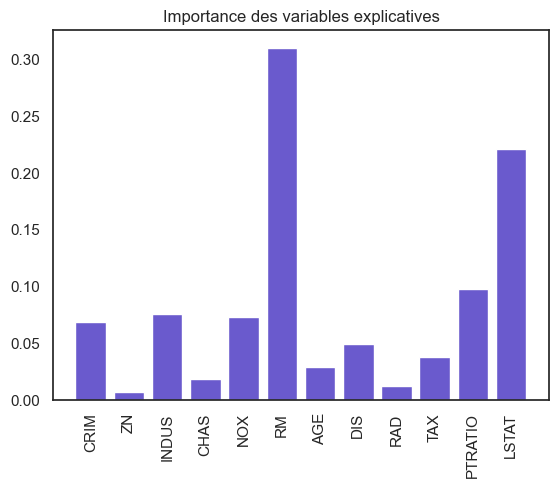

In [47]:
plt.bar(X_train_sc_data.columns, best_rfr.feature_importances_, color = "slateblue")
plt.xticks(rotation=90)
plt.title("Importance des variables explicatives")
plt.show()

Enfin, ce graphique nous montre l'importance des variables dans la construction du modèle. Les variables les plus importantes pour prédire la valeur des maisons sont le nombre moyen de pièces par logement (**RM**) et le pourcentage de la population de statut socio-économique inférieur (**LSTAT**).
   

Pour aller plus loin dans l'interprétation de ce modèle, nous allons faire appel à des méthodes d'interprétation créées pour rendre les modèles de machine learning, qualifiés de "Black Box", plus compréhensibles. <br>

Ces méthodes sont classées en deux catégories :
   - Approche globale = Interprétabilité : Compréhension générale du modèle et comment sont réalisées les prédictions
   - Approche locale = Explicabilité : Explication de prédiction individuelle

### 6) Interpréter globalement votre modèle meilleur modèle RF 
   1) Utiliser les PDP ou ALE & Permutation feature Importance 
   2) Comparer les résulats du random forest avec votre interprétation du modèle linéaire

#### Accumulated Local Effect (ALE) : Effet marginal d'une variable par intervalle sur la target (quanti)

La méthode ALE est priviligiée par rapport à PDP dans cette étude car elle **corrige la corrélation** entre les variables en supprimant les effets de celle-ci.

In [48]:
training_features = X_train_sc_data.columns
training_features

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'LSTAT'],
      dtype='object')

array([[<Axes: xlabel='CRIM', ylabel='ALE'>,
        <Axes: xlabel='ZN', ylabel='ALE'>,
        <Axes: xlabel='INDUS', ylabel='ALE'>],
       [<Axes: xlabel='CHAS', ylabel='ALE'>,
        <Axes: xlabel='NOX', ylabel='ALE'>,
        <Axes: xlabel='RM', ylabel='ALE'>],
       [<Axes: xlabel='AGE', ylabel='ALE'>,
        <Axes: xlabel='DIS', ylabel='ALE'>,
        <Axes: xlabel='RAD', ylabel='ALE'>],
       [<Axes: xlabel='TAX', ylabel='ALE'>,
        <Axes: xlabel='PTRATIO', ylabel='ALE'>,
        <Axes: xlabel='LSTAT', ylabel='ALE'>]], dtype=object)

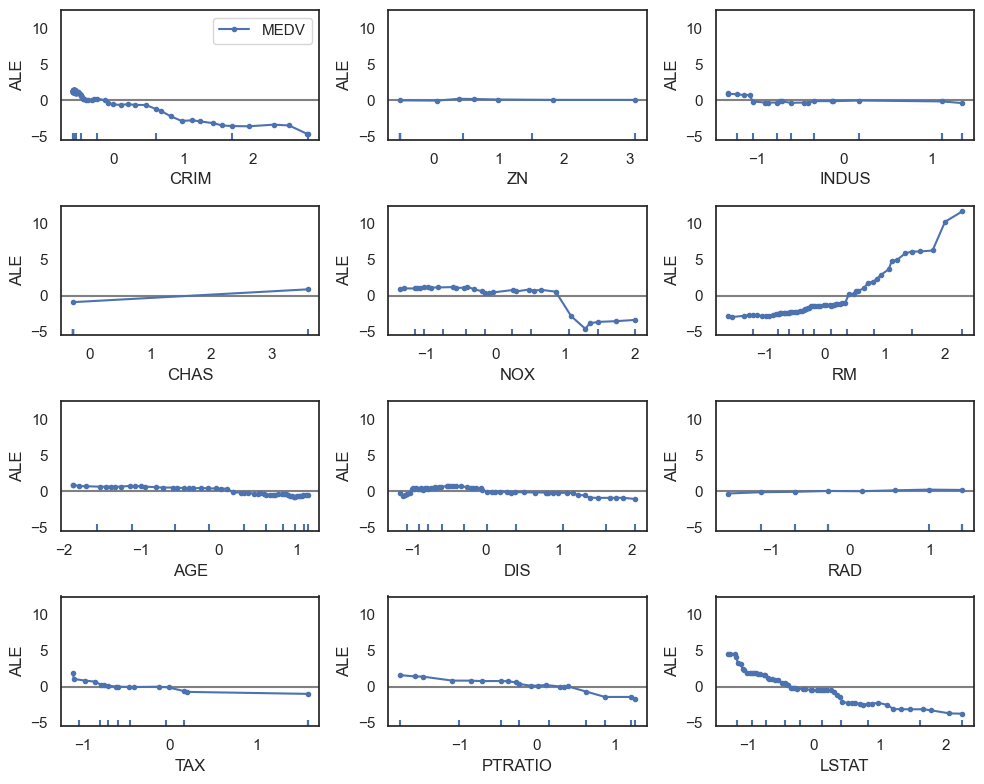

In [49]:
rfr_ale = ALE(best_rfr.predict, feature_names=training_features, target_names=["MEDV"])
rfr_exp = rfr_ale.explain(X_train_sc_data.to_numpy())

_, ax1 = plt.subplots(figsize = (10,8))
plot_ale(rfr_exp, features=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'LSTAT'], ax= ax1, targets=[0])

Étant donné que le modèle n'est pas linéaire, les tracés ALE sont également non linéaires. D'après ces graphiques, il semble que les variables **RM** (nombre moyen de pièces par logement) et **LSTAT** (pourcentage de la population de statut socio-économique inférieur) ont un fort impact sur la prédiction. Cela est en adéquation avec le graphique de l'influence des features réalisé en amont.

Le graphique concernant le nombre moyen de pièces par logement montre une courbe croissante, ce qui signifie que plus une maison dispose de pièces, plus sa valeur tend à croître. En revanche, le graphique du pourcentage de la population appartenant à un statut socio-économique inférieur indique une relation inverse : une augmentation de cette proportion est associée à une diminution de la valeur des maisons.

Par ailleurs, nous retrouvons les mêmes observations que celles issues du modèle linéaire.

#### Permutation feature Importance 

Cette méthode permet de distinguer les variables qui **participent le plus à l'erreur de prédiction** de celles qui n'y participent pas du tout.<br>

En d'autres termes, nous mesurons l’importance d’une feature en calculant l’augmentation de l’erreur de prédiction du modèle après permutation des caractèristiques de la feature.

Une caractéristique est **importante** si le mélange de ses valeurs augmente l'erreur du modèle, car dans ce cas, le modèle s'est appuyé sur la caractéristique pour la prédiction.

Une caractéristique est **sans importance** si le mélange de ses valeurs laisse l’erreur du modèle inchangée, car dans ce cas, le modèle a ignoré la caractéristique pour la prédiction.

In [50]:
result = permutation_importance(best_rfr, X_test_sc, y_test,
                           n_repeats=15,
                           random_state=0
                           )

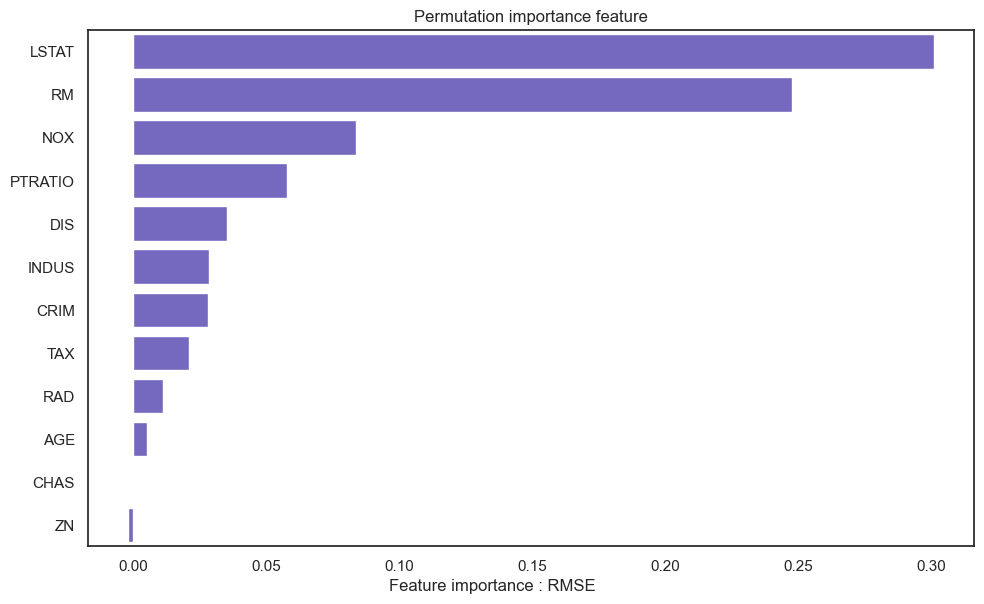

In [51]:
perm_sorted_idx = result.importances_mean.argsort()

# Trier les indices des features par importance
perm_sorted_idx = result.importances_mean.argsort()[::-1]

# Créer la figure et l'axe
fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))

X_test_sc_data = pd.DataFrame(X_test_sc, columns=X_test.columns)

# Utiliser sns.barplot pour afficher les importances des features triées
sns.barplot(
    x=result.importances_mean[perm_sorted_idx],  # Moyenne des importances
    y=X_test_sc_data.columns[perm_sorted_idx],  
    orient='h',  # Affichage horizontal
    ax=ax1, 
    color = "slateblue"
)

plt.title('Permutation importance feature')
fig.text(.5, .001, "Feature importance : RMSE", ha='center')

fig.tight_layout()
plt.show()

Au regard de ce graphique, nous pouvons observer que les variables **LSTAT** (pourcentage de la population de statut socio-économique inférieur) et **RM** (nombre moyen de pièces par logement) ressortent comme étant les plus importantes et sont suivies de **NOX** (concentration des oxydes d'azote). <br>
Ainsi, le modèle s'est principalement appuyé sur ces caractéristiques pour réaliser la prédiction de la valeur immobilière tout en ignorant les variables peu importantes comme **CHAS** (proximité ou non avec la rivière) et **ZN** (proportion de terrains résidentiels) qui ont une importance quasi-inexistante.

 Par ailleurs, le modèle linéaire a également identifié les variables **LSTAT** et **RM** comme étant les plus influentes. Cependant, la variable **DIS** figurait en troisième position après ces dernières tandis que cette méthode a déterminé qu'elle n'était pas très importante dans la prédiction.

### 7) Réaliser une explicabilité par individu sur le modèle RF
- 1) ICE, le PDP est-il une bonne représentation des variables importantes de votre modèle?
- 2) LIME
- 3) SHAP watterfall plot

#### Individual Conditional Expectation (ICE)

Les **Individual Conditional Expectation (ICE) plots** permettent de tracer sur un graphique une ligne par instance qui montre comment la prédiction d'une instance est impactée si on fait varier la valeur d'une feature.

Cette méthode est **basée sur les PDP**, la PDP représente l'effet moyénniser de toutes les courbes ICE. La méthode est donc exactement la même, on fait varier notre feature d'intérêt tout en fixant à leur valeur moyenne les autres features.

Le **partial depence plot ou (PDP)** nous montre l'effet marginal **d'une ou 2 variables sur la target** que nous cherchons à prédire. PDP peut donc nous montrer la nature de la relation existante entre une variable du modèle et la target que celle-ci soit linaire ou non linéaire, monotone ou même plus complexe.


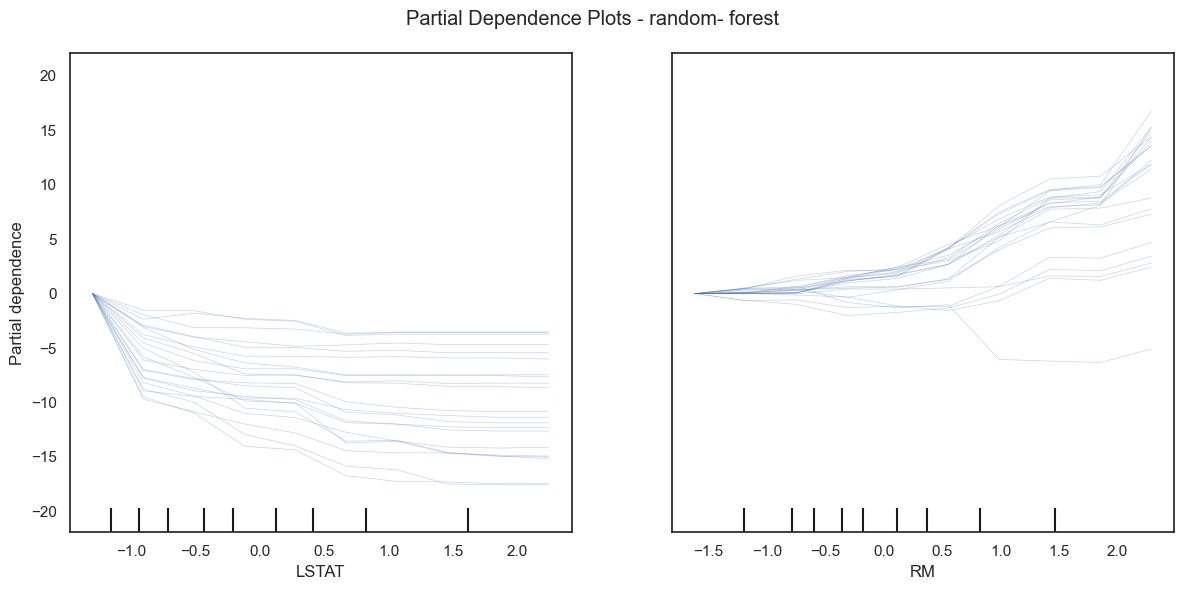

In [52]:
from sklearn.inspection import partial_dependence, PartialDependenceDisplay

# ICE pour plusieurs caractéristiques quantitatives
features = ["LSTAT","RM"]  # Index des caractéristiques les plus importantes

_, ax1 = plt.subplots(figsize = (12,6))
PartialDependenceDisplay.from_estimator(best_rfr,  #le modèle
                                         X_train_sc_data, 
                                         features=features,
                                         kind="individual", 
                                         ax = ax1,
                                         grid_resolution=10, # Nombre de points estimés pour le tracer de la courbe
                                         n_cols=3,
                                         subsample=0.05, # 5% du jeu de données
                                         centered=True
                                         )
plt.suptitle("Partial Dependence Plots - random- forest")
plt.tight_layout()
plt.show()

Nous observons que les lignes (chaque ligne représente un individu) suivent à peu près la même trajectoire pour les deux variables. Par exemple, lorsque le nombre moyen de pièces par logement (**RM**) augmente, la valeur des maisons (**MEDV**) augmente de manière similaire pour tous les individus.
Cela signifie que l'effet semble similaire chez nos individus. <br>
Le PDP peut donc être un bon résumé des relations entre nos features et la variable à prédire.

#### Local surogate (Lime)

L'algorithme LIME( Local interpretable model-explanation ) est une méthode d'explicabilité conçue pour interpréter des modèles black box comme la forêt aléatoire.

L'idée est d'expliquer localement la prédiction d'un modèle en utilisant un modèle plus simple et compréhensible dans un voisinage spécifique de l'exemple à expliquer (Reg linéaire, arbre, Lasso, ...)

In [53]:
import lime
import lime.lime_tabular

#Création de l'explainer
explainer = lime.lime_tabular.LimeTabularExplainer(X_train_sc, 
                                                   feature_names=training_features , #Nom des features du modèle
                                                   class_names=['MEDV']  , #Variable à predire
                                                   verbose=True,
                                                     mode='regression' # Classification ou régression
                                                     )
# Index de l'individu à prédire
i = 50

# Résultat de l'explainer
exp = explainer.explain_instance(X_test_sc_data.loc[i], best_rfr.predict, num_features=5)

Intercept 25.578059286192776
Prediction_local [20.73362064]
Right: 21.594731985924465


In [54]:
#Afficher lime explainer in notebook
exp.show_in_notebook(show_table=True)

A gauche, nous pouvons lire la valeur prédite par notre modèle local pour l'individu choisi. Ici, le modèle a prédit une valeur de 21.59 pour l'individu 50.

Au centre, nous pouvons lire l'effet des variables discrétisées sur la prédiction. Cela permet de comprendre pourquoi le modèle a prédit cette valeur pour cet individu. Nous observons que le modèle a sélectionné 4 variables qui contribuent à la baisse de la prédiction (**RM**, **LSTAT**, **CHAS** et **DIS**) et 1 variable qui tire la prédiction vers le haut (**PTRATIO**). Toutefois, **RM** et **LSTAT** restent les plus importantes accompagnées de **CHAS** (proximité ou non avec la rivière), rendant ainsi négligeable l'effet des autres variables. Ainsi, la faible prédiction s'explique principalement par le fait que le logement possède peu de pièces (2.23) car elle a une valeur élevée négative d'après le tableau de droite.

### 8) Explorer les graphiques SHAP étudiés  dans la partie CM
   1) beeswarm (Contribution des variables)
   2) scatter (équivalent pdp)
   
Pour clôturer le travail, nous allons nous intéresser aux valeurs de shapley qui sont issues de la théorie des jeux. Plus particulièrement, nous allons nous focaliser sur leur utilisation dans l'interprétation des modèles black box avec les shapleys additive exPlanations AKA SHAP. <br>
La Shapley value correspond à la valeur moyenne pondérée de la contribution marginale des joueurs.

#### beeswarm (Contribution des variables)

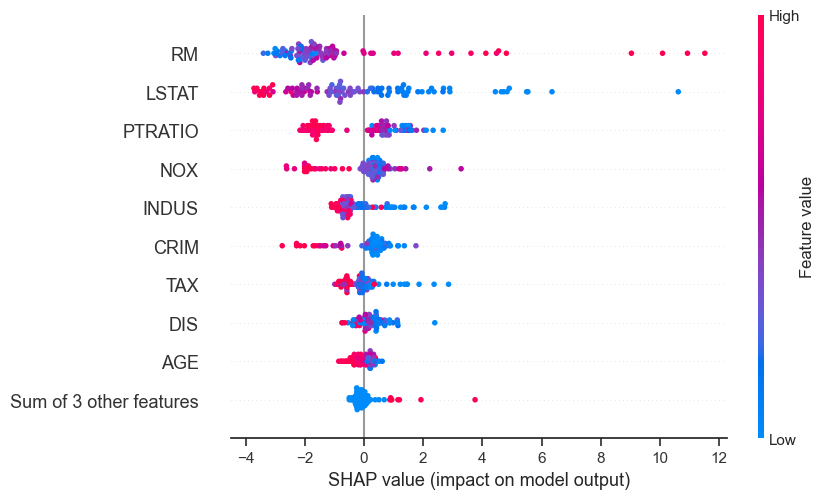

In [55]:
import shap

# Création de l'explainer pour Random Forest
explainer = shap.TreeExplainer(best_rfr)

# Calcul des valeurs SHAP pour un sous-ensemble des données
shap_values = explainer(X_train_sc_data.iloc[1:100])

#Graphique beeswarm, interprétabilité globale 
shap.plots.beeswarm(shap_values)

Nous retrouvons les variables influentes placées en haut de l'axe des features, à savoir **RM** et **LSTAT**. Plus elles sont hautes, plus elles ont une influence sur la shapley value. Leur influence est également observable par l'étendue de leur distribution. En effet, nous voyons que ces variables ont les distributions les plus larges. Enfin, nous remarquons que pour ces deux variables des valeurs élevées et faibles s'entremèlent, ce qui signifie que la relation n'est pas monotone pour chacune des deux variables avec la target.

#### scatter (équivalent pdp)

Cette fois-ci, nous nous intéressons à l'effet des deux variables les plus importantes sur notre target.

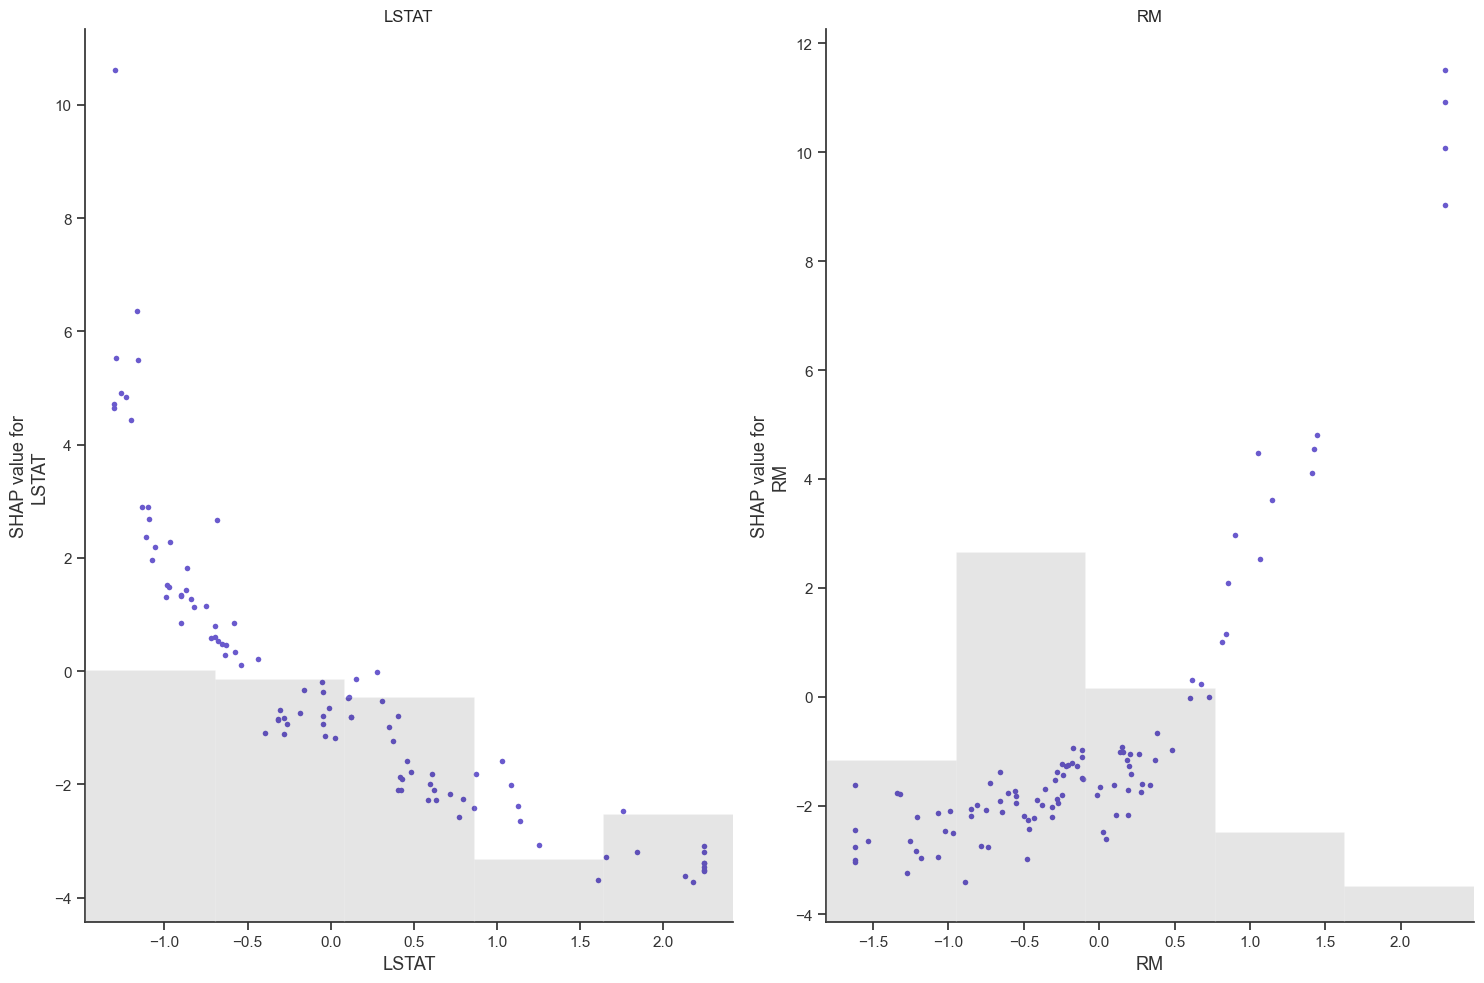

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(15, 10))

#Graphique SHAP pour 'LSTAT'
shap.plots.scatter(shap_values[:, 'LSTAT'], show=False, ax=axes[0])
axes[0].collections[0].set_facecolor('slateblue')
axes[0].set_title('LSTAT')

#Graphique SHAP pour 'RM'
shap.plots.scatter(shap_values[:, 'RM'], show=False, ax=axes[1])
axes[1].collections[0].set_facecolor('slateblue') 
axes[1].set_title('RM')

plt.tight_layout()
plt.show()

Les graphiques montrent l’effet des variables **LSTAT** (pourcentage de la population de statut socio-économique inférieur) et **RM** (nombre moyen de pièces par logement) sur les prédictions du modèle à l’aide des valeurs SHAP. <br>
Plus précisément, plus la part de la population défavorisée augmente, plus le modèle affecte une valeur faible à l'estimation immobilière. A l'inverse, l'augmentation du nombre moyen de pièces par logement incite le modèle à prédire une valeur élevée de l'estimation immobilière.

Enfin, les histogrammes en gris indiquent la distribution de chacune de nos variables.
